# Make Animation from pickels files

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import platform
from joblib import Parallel, delayed

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'

In [2]:
import multiprocessing
from joblib import Parallel, delayed
num_jobs=30

In [3]:
## Task specific imports
import os as os
#import keras.utils as image
import glob
from PIL import Image, ImageDraw
import pickle

In [4]:
import math
import time

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [5]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"
    
if Computer ==  "SciClone":
    rootfolder = '/sciclone/scr10/dchendrickson01/EFIT/'
    
else:
    asdfasdf

## Load data

In [6]:
Case = '20m15XRfRqb'
CasesAtaTime = 2
FilesAtTime = 5
ProcessPerFile = 5
Position = 0 #0 Energy, 1 X axis, 2 Y Axis, 3 X axis
skips = 2 #1 every data point, or skip what modulous

imFolder=rootfolder+Case+'/'
fileNames = glob.glob(imFolder+'Movements*.p')

Views=[]

In [7]:
fileName = imFolder+'Parameters.p'

file=open(fileName,'rb')
Parameters=pickle.load(file)

file.close()


In [8]:
xmax = Parameters["LargestXnode"]
ymax = Parameters["LargestYnode"]
zmax = Parameters["LargestZnode"]
gridStartWeb = Parameters["WidthStartWebNode"]
gridEndWeb = Parameters["WidthEndWebNode"]
gridEndFoot = Parameters["HeightEndFootNode"]
gridStartHead = Parameters["HeightStartHeadNode"]
gridStartHeadWidth = Parameters["WidthStartHeadNode"]
gridEndHeadWidth = Parameters["WidthEndHeadNode"]
DataBucketSize = Parameters["SaveEveryXStep"]

In [9]:
Parameters

{'AirCut': False,
 'RailShape': True,
 'Flaw': False,
 'Length': 20,
 'Width': 0.1524,
 'Height': 0.1524,
 'SaveFolder': '/sciclone/scr10/dchendrickson01/EFIT/20m15XRfRqb/',
 'RunTitle': '20m Rail At 15x long for 1k FP',
 'TiesIncluded': 0,
 'GridDesignFrequency': 74574,
 'InputSignalFrequency': 16300,
 'SimulationCycleLength': 60,
 'ForcingFuctionNumber': 6,
 'PerWheelForce': 173000,
 'PoisonsRatio': 0.29,
 'YoungsModulous': 200000000000,
 'MaterialDensity': 7800,
 'LongitudinalWaveSpeed': 5796.653896162343,
 'TransverseWaveSpeeed': 3152.519949406393,
 'TimeStepsSimLength': 18193,
 'GridLengthNodes': 6000,
 'GridWidthNodes': 45,
 'GridHeightNodes': 45,
 'LargestXnode': 5678,
 'LargestYnode': 44,
 'LargestZnode': 44,
 'SaveEveryXStep': 125,
 'HeightStartHeadNode': 29,
 'WidthStartWebNode': 17,
 'WidthEndWebNode': 27,
 'HeightEndFootNode': 9,
 'WidthStartHeadNode': 8,
 'WidthEndHeadNode': 36,
 'AbsorberLengthNodes': 101,
 'AbsorptionPerNode': 0.5,
 'ExpectedGoodData': 13576.298409016745

## Image making functions

In [10]:
def getFigData(fileName, Position, skips, xStart, xEnd, yStart, yEnd, zStart, zEnd):
    
    file=open(fileName,'rb')
    temp = pickle.load(file)
    file.close()
    
    Data = temp[Position][:,:,:,0::skips]
    
    del temp


    if xStart == xEnd:
        ReturnData = Data[xStart,:,:,:]
        ReturnData[:gridStartWeb-1,gridEndFoot+2:gridStartHead-2] = np.nan
        ReturnData[:gridStartHeadWidth-1,gridStartHead-2:] = np.nan
        ReturnData[gridEndWeb+2:,gridEndFoot+2:gridStartHead-1] = np.nan
        ReturnData[gridEndHeadWidth+4:,gridStartHead-1:] = np.nan
        
    elif yStart == yEnd:
        ReturnData = Data[:,yStart,:,:]
    elif zStart == zEnd:
        ReturnData = Data[:,:,zStart,:]
    else:
        print('Error no dimmension is a plane')
        ReturnData = []
        
        
    return ReturnData, int(fileName[-5:][:3])

In [11]:
def SimpleFig(Data, t, v, figW, figH, Folder):
    
    fig = plt.figure(figsize=(figH,figW), dpi=300)

    Data = Data.T
    
    #print(Data.shape)
    
    plt.contourf(Data, v, cmap=plt.cm.jet)
    plt.title(Folder+' '+str(t))
    plt.savefig(imFolder+Folder+'/DataFrame'+str(t).zfill(5)+'.png')
    
    fig.clf()
    plt.close(fig)
    del fig

    return 0

In [12]:
def CaseImage(View):
    imfolder = rootfolder + Case + '/'+View+'/'
    files = glob.glob(os.path.join(imfolder, '*.png'))
    files.sort()
    images = []

    for file in files:
        images.append(image.load_img(file))
    images[0].save(rootfolder + Case + '/Animated_'+View+'.gif',
        save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
    return 0

In [13]:
def runCase(Case, skips):
    
    Position = Case[7]
    xStart = Case[0]
    xEnd = Case[1]
    yStart = Case[2]
    yEnd = Case[3]
    zStart = Case[4]
    zEnd = Case[5]
    Folder = Case[6]
    
    temp = Parallel(n_jobs=FilesAtTime)(delayed(getFigData)
                                        (fileName, Position, skips, xStart, xEnd, yStart, yEnd, zStart, zEnd) 
                                        for fileName in fileNames[:5])
    
    StackData = np.zeros((temp[0][0].shape[0],temp[0][0].shape[1],1))
    
    for group in temp:
        StackData = np.concatenate((StackData,group[0]),axis=2)
    del temp
    
    EMin = np.min(StackData)
    EMax = np.max(StackData)
    v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]
    
    if os.path.isdir(imFolder+Folder):
        pass
    else:
        os.makedirs(imFolder+Folder)
        
    figW = 6
    figH = figW * (StackData.shape[0]/StackData.shape[1])
    
    #print(StackData[:,:,1].T.shape,StackData[:,:,17].T.shape,StackData[:,:,99].T.shape)
    
    #Parallel(n_jobs=ProcessPerFile)(delayed(SimpleFig)
    #                                (StackData[:,:,i], i, v, figW, figH, Folder)
    #                                for i in range(StackData.shape[2]))
    for i in range(StackData.shape[2]):
        a = SimpleFig(StackData[:,:,i], i, v, figW, figH, Folder)
    
    del StackData
    #temp = CaseImage(Folder)

In [14]:
def getStackData(Case, skips):
    
    xStart = Case['xstart']
    xEnd = Case['xend']
    yStart = Case['ystart']
    yEnd = Case['yend']
    zStart = Case['zstart']
    zEnd = Case['zend']
    Folder = Case['name']
    Position = Case['Position']
    
    temp = Parallel(n_jobs=FilesAtTime)(delayed(getFigData)
                                        (fileName, Position, skips, xStart, xEnd, yStart, yEnd, zStart, zEnd) 
                                        for fileName in fileNames)
    
    StackData = np.zeros((temp[0][0].shape[0],temp[0][0].shape[1],1))
    
    for group in temp:
        StackData = np.concatenate((StackData,group[0]),axis=2)
    del temp
    
    return StackData

## make all the frames of all the cases

In [28]:
DataCases = {
             'EndM4': {
                       'name'     : 'EndM4',
                       'xstart'   : xmax - 4,
                       'xend'     : xmax - 4,
                       'ystart'   : 0,
                       'yend'     : ymax,
                       'zstart'   : 0,
                       'zend'     : zmax,
                       'Position' : 0
                      },
             'EndM4y': {
                       'name'     : 'EndM4y',
                       'xstart'   : xmax - 4,
                       'xend'     : xmax - 4,
                       'ystart'   : 0,
                       'yend'     : ymax,
                       'zstart'   : 0,
                       'zend'     : zmax,
                       'Position' : 2
                      },
             'EndM6': {
                       'xstart'   : xmax - 6,
                       'xend'     : xmax - 6,
                       'ystart'   : 0,
                       'yend'     : ymax,
                       'zstart'   : 0,
                       'zend'     : zmax,
                       'Position' : 0
                      },
             'EndM2': {
                       'name'     : 'EndM2',
                       'xstart'   : xmax - 2,
                       'xend'     : xmax - 2,
                       'ystart'   : 0,
                       'yend'     : ymax,
                       'zstart'   : 0,
                       'zend'     : zmax,
                       'Position' : 0
                      },
             'EndM2y': {
                       'name'     : 'EndM2y',
                       'xstart'   : xmax - 2,
                       'xend'     : xmax - 2,
                       'ystart'   : 0,
                       'yend'     : ymax,
                       'zstart'   : 0,
                       'zend'     : zmax,
                       'Position' : 2
                      },
             'EndM2x': {
                       'name'     : 'EndM2x',
                       'xstart'   : xmax - 2,
                       'xend'     : xmax - 2,
                       'ystart'   : 0,
                       'yend'     : ymax,
                       'zstart'   : 0,
                       'zend'     : zmax,
                       'Position' : 1
                      },
             'WebStart': {
                       'name'     : 'WebStart',
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridStartWeb+1,
                       'yend'     : gridStartWeb+1,
                       'zstart'   : gridEndFoot,
                       'zend'     : gridStartHead,
                       'Position' : 1
                      },
             'WebEnd': {
                       'name'     : 'WebEnd',
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridEndWeb-1,
                       'yend'     : gridEndWeb-1,
                       'zstart'   : gridEndFoot,
                       'zend'     : gridStartHead,
                       'Position' : 1
                      },
             'HeadEnd': {
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridEndHeadWidth-1,
                       'yend'     : gridEndHeadWidth-1,
                       'zstart'   : gridStartHead,
                       'zend'     : zmax,
                       'Position' : 2
                      },
             'HeadStart': {
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridStartHeadWidth+1,
                       'yend'     : gridStartHeadWidth+1,
                       'zstart'   : gridStartHead,
                       'zend'     : zmax,
                       'Position' : 0
                      },
             'TopSurface': {
                       'name'     : 'TopSurface',
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridStartHeadWidth-1,
                       'yend'     : gridEndHeadWidth+1,
                       'zstart'   : zmax-3,
                       'zend'     : zmax-3,
                       'Position' : 0
                      },
             'LeftHead': {
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridStartHeadWidth,
                       'yend'     : gridStartHeadWidth,
                       'zstart'   : gridStartHead,
                       'zend'     : zmax,
                       'Position' : 1
                      },
             'RightHead': {
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridEndHeadWidth,
                       'yend'     : gridEndHeadWidth,
                       'zstart'   : gridStartHead,
                       'zend'     : zmax,
                       'Position' : 1
                      },
             'MiddleHeadPlane': {
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : 0,
                       'yend'     : ymax,
                       'zstart'   : int((zmax - gridStartHead)/2)+gridStartHead,
                       'zend'     : int((zmax - gridStartHead)/2)+gridStartHead,
                       'Position' : 1
                      },
             'MiddleWebPlane': {
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : gridStartWeb,
                       'yend'     : gridEndWeb,
                       'zstart'   : int(zmax/2),
                       'zend'     : int(zmax/2),
                       'Position' : 1
                      },
             'MiddleVerticalPlane': {
                       'xstart'   : 0,
                       'xend'     : xmax ,
                       'ystart'   : int(ymax/2),
                       'yend'     : int(ymax/2),
                       'zstart'   : 0,
                       'zend'     : zmax,
                       'Position' : 1
                      }
    
}

In [29]:
stime = time.time()

job = 'EndM2y'

Data = getStackData(DataCases[job],15)

file=open(imFolder+'Data-'+job+'.p','wb')
pickle.dump(Data,file)
file.close()

print(int((time.time()-stime)/60.0*100)/100)


280.59


In [ ]:
stime = time.time()

job = 'EndM2x'

Data = getStackData(DataCases[job],15)

file=open(imFolder+'Data-'+job+'.p','wb')
pickle.dump(Data,file)
file.close()

print(int((time.time()-stime)/60.0*100)/100)


348.52


In [21]:
Data.shape

(45, 45, 892)

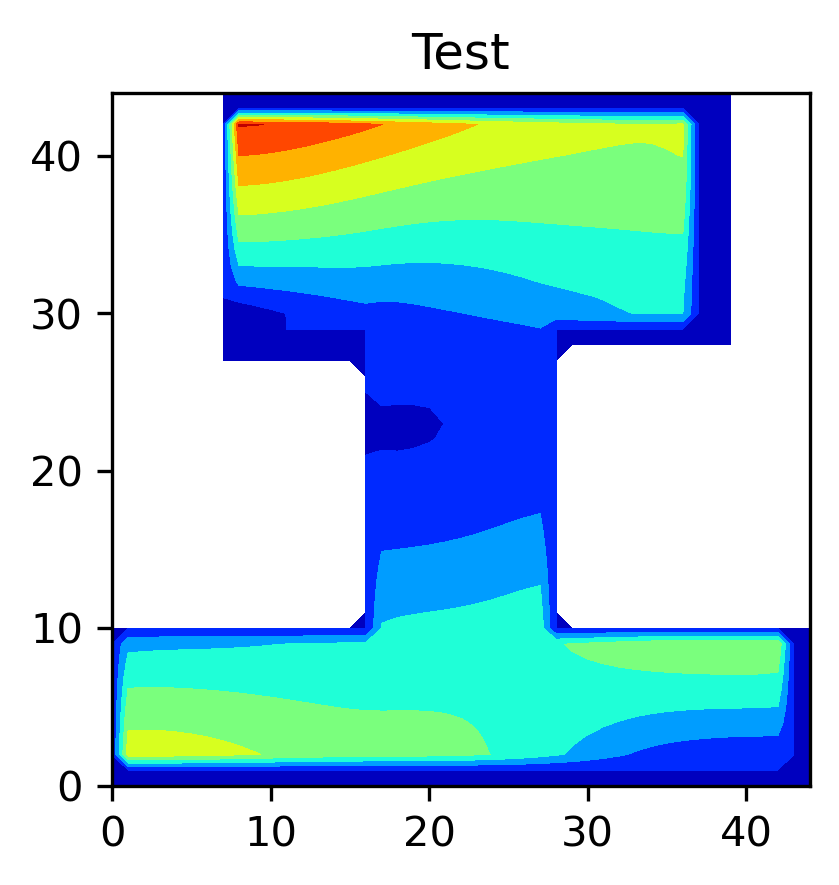

In [24]:
fig = plt.figure(figsize=(3,3), dpi=300)

EMin = np.min(Data[:,:,800])
EMax = np.max(Data[:,:,800])
v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]

plt.contourf(Data[:,:,400].T, cmap=plt.cm.jet)
plt.title('Test')
plt.show()

In [34]:
Data[:,:,800]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 1.46074034e-11, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 2.84122082e-12, 1.62071617e-11, ...,
                   nan,            nan,            nan],
       ...,
       [0.00000000e+00, 4.13292166e-11, 4.43224097e-11, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan]])

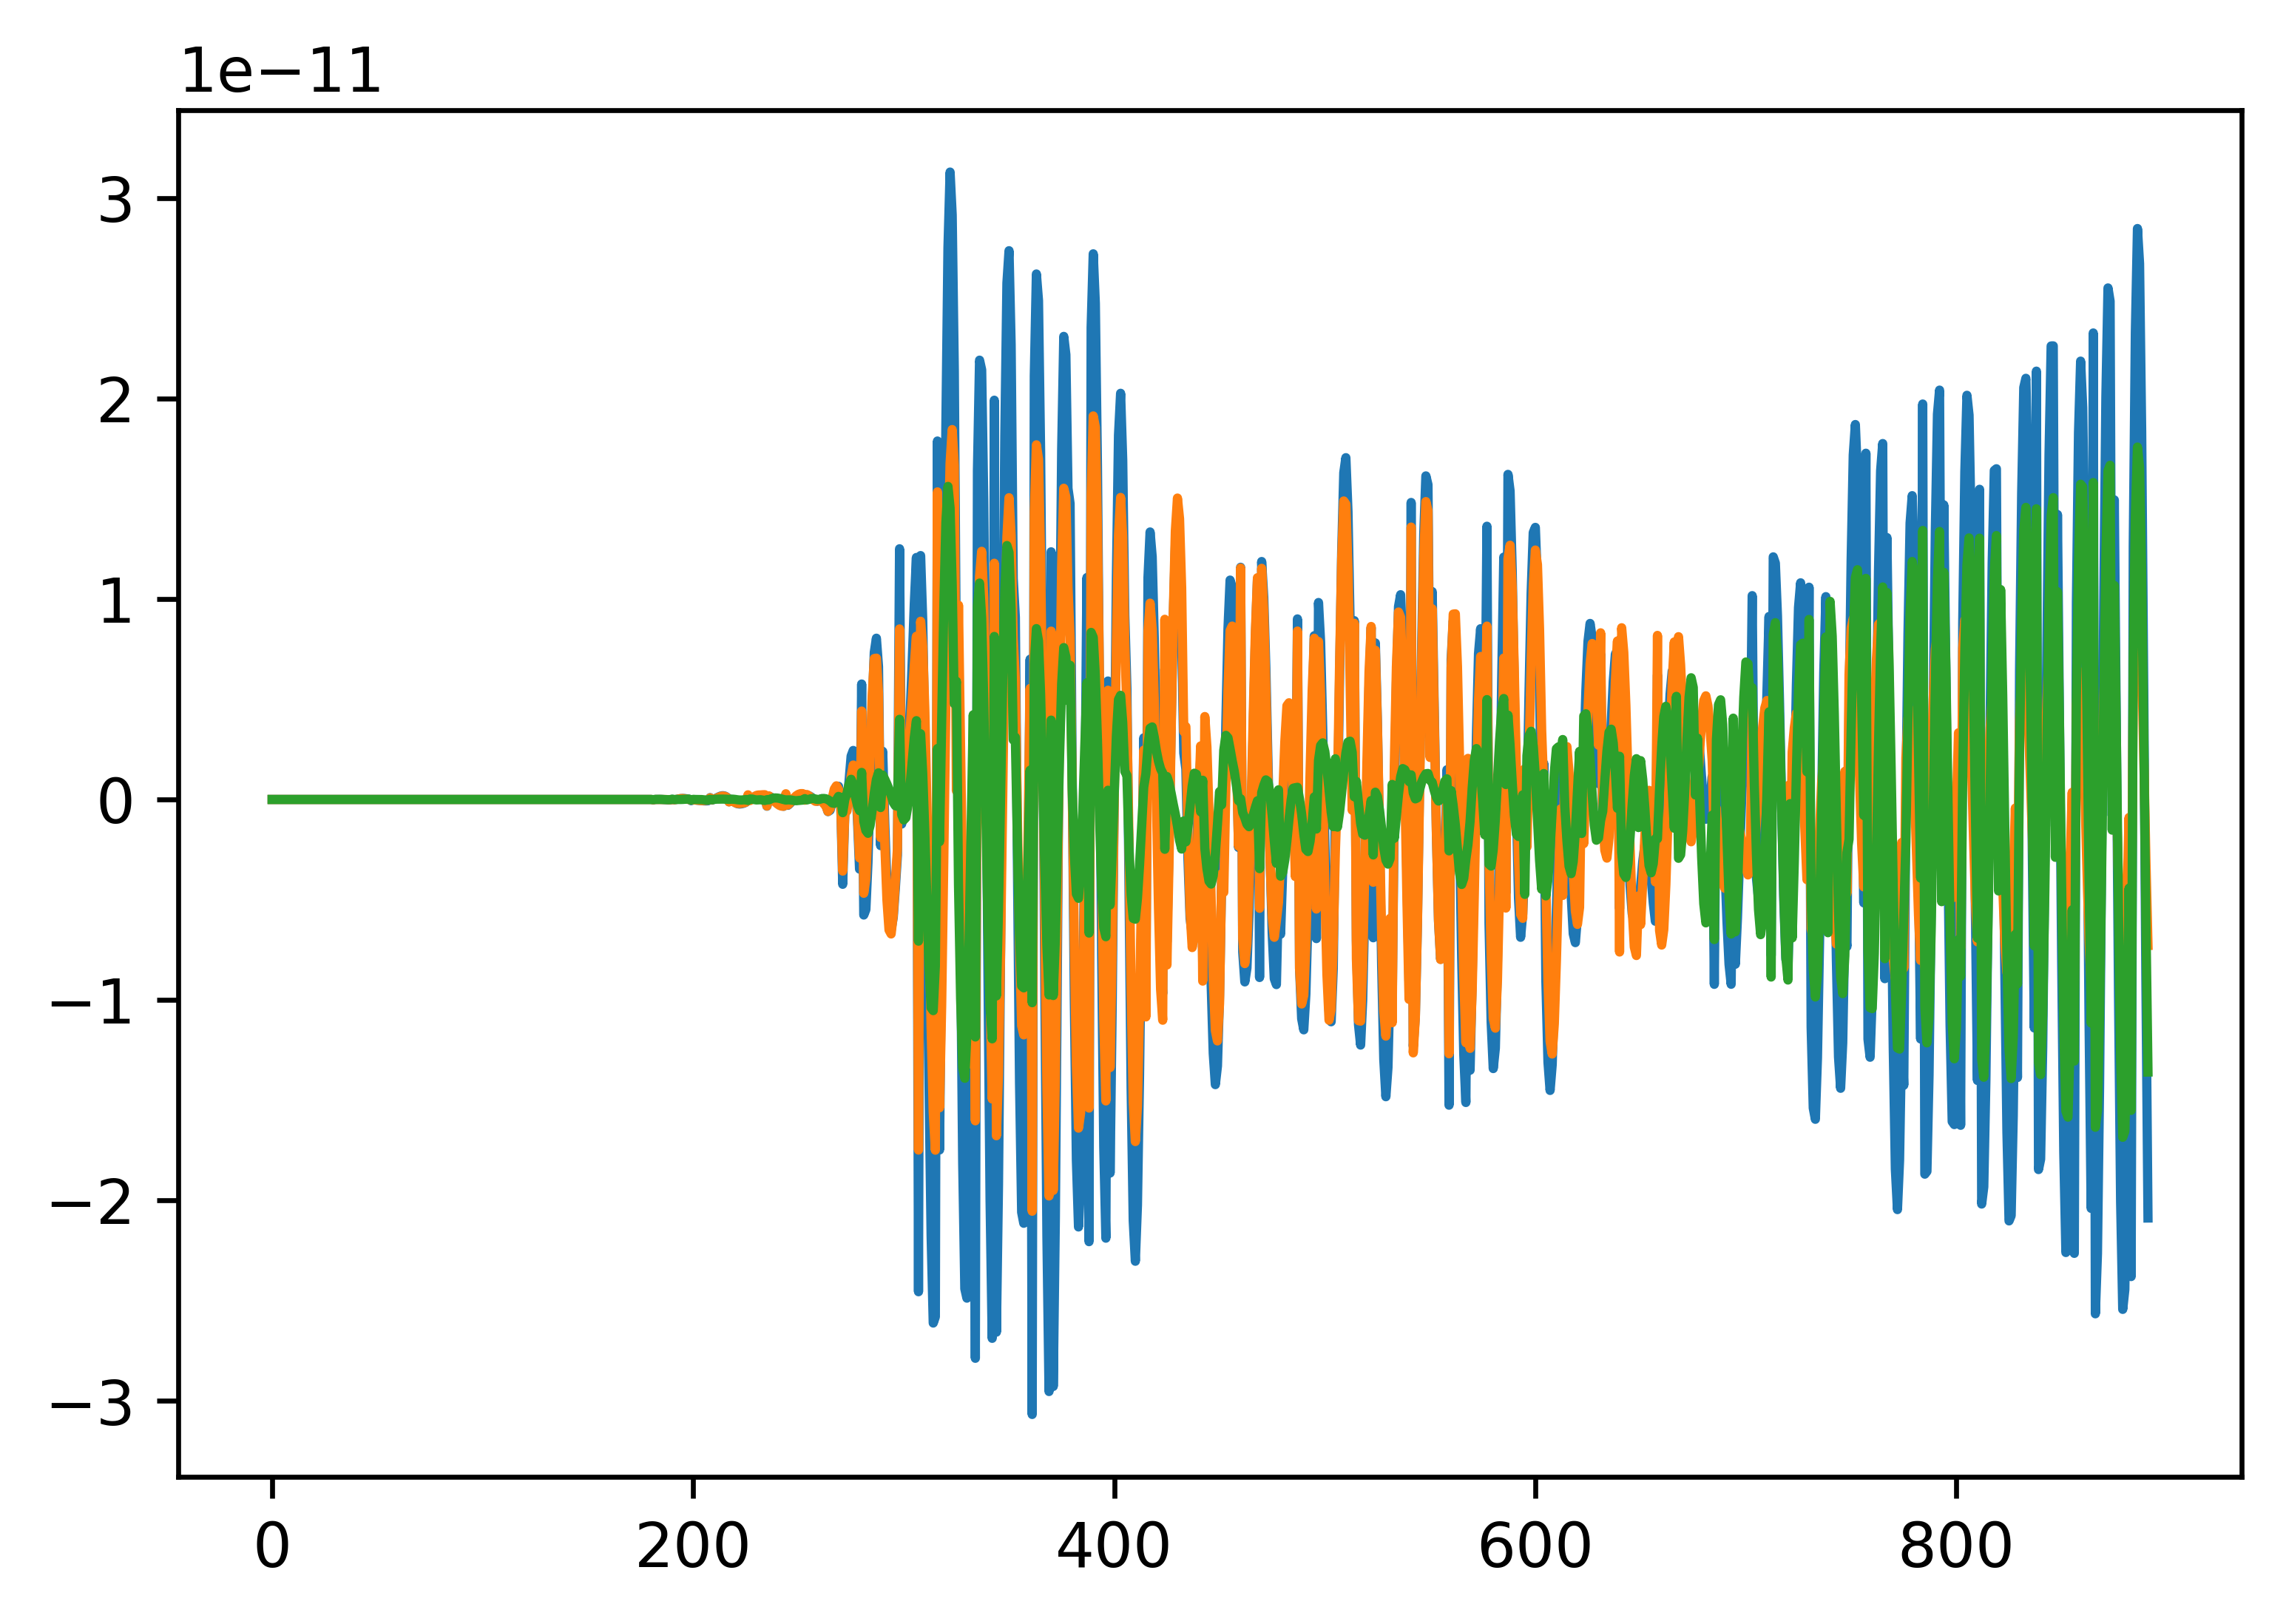

In [25]:
fig = plt.figure(figsize=(6,4),dpi=600)
plt.plot(Data[20,20,:])
plt.plot(Data[20,25,:])
plt.plot(Data[20,20,:]-Data[20,25,:])
plt.show()

In [22]:
import matplotlib.animation as animation
from multiprocessing import Pool


NameError: name 'asdf' is not defined

In [ ]:
stime = time.time()

fig, ax = plt.subplots(figsize=(9,3), dpi=300)

startCut = 0
endCut = 139


def update(frame):
    im = ax.contourf(Data[:,:,frame+startCut].T, v, cmap=plt.cm.jet)
    return im
    
ani = animation.FuncAnimation(fig, update, frames=Data.shape[2]-startCut-endCut, interval=50, blit=False)

ani.save(imFolder+'WebEnd1100.gif', writer="pillow")

print(int((time.time()-stime)/60.0*100)/100)

In [ ]:
asdf

In [ ]:
skips=2
#Parallel(n_jobs=CasesAtaTime)(delayed(runCase)(GifToMake, skips) for GifToMake in GifsToMake)
for GifToMake in GifsToMake[12:]:
    print(GifToMake[6])
    runCase(GifToMake, skips)

## Animate

In [ ]:
CaseImage(GifsToMake[12][6])

## Archive Functions

In [ ]:
def EnergyFig(Data, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, v, figH, t):

    fig = plt.figure(figsize=(6,figH), dpi=300)

    Image = Data[xStart:xEnd, yStart:yEnd, zStart:zEnd].T

    x,y,z = np.shape(Image)
    if x ==1:
        I2 = np.squeeze(Image, axis=(0,))
        I2[:gridStartWeb,gridEndFoot:gridStartHead] = np.nan
        I2[:gridStartHeadWidth,gridStartHead:] = np.nan
        I2[gridEndWeb:,gridEndFoot:gridStartHead] = np.nan
        I2[:gridEndHeadWidth,gridStartHead:] = np.nan
        
    if y ==1:
        I2 = np.squeeze(Image, axis=(1,))
    if z ==1:
        I2 = np.squeeze(Image, axis=(2,))

    plt.contourf(I2, v, cmap=plt.cm.jet)
    plt.title(Folder+' '+str(t))
    plt.savefig(imFolder+Folder+'/Energy'+str(t).zfill(5)+'.png')
    plt.close(fig)


In [ ]:
def RunView(fileNames, 
            xStart, xEnd, yStart, yEnd, zStart, zEnd, 
            Folder, DataBucketSize, Position, skips,
            FoundMin = [], FoundMax = []):
    
    if len(FoundMin) == 0:
        MinMax = Parallel(n_jobs=FilesAtTime)(delayed(getMinMax)(fileName, Position) for fileName in fileNames)
    
        MinMax = np.matrix(MinMax)
    
        EMin = np.min(MinMax[:,0])
        EMax = np.max(MinMax[:,1])
    
    else:
        EMin = FoundMin
        Emax = FoundMax
        
    v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]
    
    temp = Parallel(n_jobs=FilesAtTime)(delayed(PickleToImages)
                                        (fileName, 
                                         xStart, xEnd, yStart, yEnd, zStart, zEnd, 
                                         Folder, v, DataBucketSize, Position, skips) 
                                        for fileName in fileNames)
    temp = CaseImage(Folder)
    
    return Emin, EMax

In [ ]:
def PickleToImages(fileName, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, v, DataBucketSize, Position = Position, skips = skips):
    
    Data, FilePosition = getMovements(fileName, Position, skips)
    
    AnimationBook(Data, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, start = FilePosition * DataBucketSize, v=v)
    
    return 0

In [ ]:
# %%
def AnimationBook(Data, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, start = 0, v = []):
    
    steps = np.shape(Data)[3]
    
    if os.path.isdir(imFolder+Folder):
        pass
    else:
        os.makedirs(imFolder+Folder)
    if xStart - xEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (zEnd-zStart)
        xEnd+=1
    elif yStart - yEnd == 0.0:
        figH = 6 * (zEnd - zStart) / (xEnd-xStart)
        yEnd+=1
    elif zStart - zEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (xEnd-xStart)
        zEnd+=1
    else:
        figH = 0

    if figH==0:
        print("Error, no Dimmension is a plane",yStart-yEnd)
    else:
        if len(v) == 0: 
            EMin = np.min(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
            EMax = np.max(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
            v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]

        #print('About to make frames for ',Folder)
        #temp = Parallel(n_jobs=ProcessPerFile)(delayed(EnergyFig)(Data[:,:,:], xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder,v,figH, start+t) for t in range(steps))
        for t in range(np.shape(Data)[3]):
            a = EnergyFig(Data[:,:,:,t], xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder,v,figH, start+t) 
    plt.close('all')


In [ ]:
def getMinMax(fileName, Position =0):
    file=open(fileName,'rb')
    temp = pickle.load(file)
    file.close()
    
    Data = temp[Position]
    
    del temp
    
    fileMin = 0.0
    fileMax = 0.0
    
    for i in range(np.shape(Data)[3]):
        Min = np.min(Data[:,:,:,i])
        Max = np.max(Data[:,:,:,i])
        
        if Min < fileMin: 
            fileMin = Min
        if Max > fileMax:
            fileMax = Max
    
    return fileMin, fileMax
        

In [ ]:
#for fileName in fileNames:
def getMovements(fileName, Position =0, skips=1):
    
    file=open(fileName,'rb')
    temp = pickle.load(file)
    file.close()
    
    [Movement, MovementsX, MovementsY, MovementsZ] = temp

    Data = temp[Position][:,:,:,0::skips]
    
    return Data, int(fileName[-5:][:3])